# Finetuning Latin BERT and Generating New Text
This notebook is devoted to fine-tuning LatinBERT on particular author subsets and generating on updated weights. 

Regardless, of whether fine-tuning or generating new text, these imports are necessary:

In [ ]:
import numpy as np
import os, re
from Data import dataExp
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, TextDataset, DataCollatorForLanguageModeling
from tensor2tensor.data_generators import text_encoder

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<hr>

## Fine-tuning
Now, we can focus on fine-tuning LatinBERT for a specific author. First, let's define the author here so it doesn't need to be repeatedly changed when we want to fine-tune on a new author. We also define some parameters for the fine-tuning of the model later.

In [ ]:
# Define the number of training epochs
num_epochs = 100

# Define the batch size
batch_size = 8

# Define lists for storing the training loss
train_loss_step = []
train_loss_epoch = []

log_interval = 20
author = "Caesar"

After selecting the author, we load the Corpus Interface and the text for the given author.

In [ ]:
CI = dataExp.CorpusInterface(corpus_name="text_corpus.pickle", shouldTokenize = False)
text = CI.get_text_for_author(author=author,shouldShuffle=True)

Let's save the author's text into a text file and print how long it is. We put into a text file because there is a HuggingFace class that can create a dataset out of a text file and we print the length purely for research/interest purposes.

In [4]:
with open(f"{author}_data.txt", "w+") as f:
    f.write(text)
print(len(text))

1473628


Now, we load in the default LatinBERT model and tokenizer weights, and put it on the device (to make use of the GPU if possible)

In [ ]:
path_to_latin_bert = "./LatinBERT/"
tokenizer = AutoTokenizer.from_pretrained(path_to_latin_bert)
model = AutoModelForMaskedLM.from_pretrained(path_to_latin_bert+"latin_bert/")
model.to(device)

The next function ends up not being used, but I had experimented with defining a custom collate function so thatprocess of creating a data loader could also be done on the GPU rather than the CPU, which increased the wait times for the code.

In [6]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item[0]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item[1]) for item in batch])
    labels = torch.stack([torch.tensor(item[2]) for item in batch])

    # Move data to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


We now create a dataset, the collator, (both from HuggingFace) and then the PyTorch data loader for the model

In [7]:
from torch.utils.data import DataLoader

dataset = TextDataset(file_path=f"{author}_data.txt", tokenizer=tokenizer, block_size=256)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.35)

train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)


/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (352137 > 512). Running this sequence through the model will result in indexing errors


We also save the data_loader, so that the lengthy process of running the above need not be done multiple times.

In [8]:
import pickle
def save_object(obj, filename):
    with open(filename, "wb") as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(train_dataloader, f"{author}_dataset.pickle")

Now, we choose the optimizer and learning rate scheduler followed by the training loop for fine-tuning the model.
In the training loop, we also keep track of the loss at each epoch and at every step to plot how well the model is learning.

In [9]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [ ]:
torch.cuda.empty_cache()

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    epoch_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        # forward pass
        
        outputs = model(input_ids=batch['input_ids'].to(device),labels=batch['labels'].to(device))
        loss = outputs.loss
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        epoch_train_loss+=train_loss
        train_loss_step.append(loss.item())
        
        # log training progress
        if (step + 1) % log_interval == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Step [{step + 1}/{len(train_dataloader)}]: Train loss = {train_loss / log_interval}")
            train_loss = 0
            
    train_loss_epoch.append(epoch_train_loss / len(train_dataloader))

Now that the model has been trained, we can plot and save the learning curves

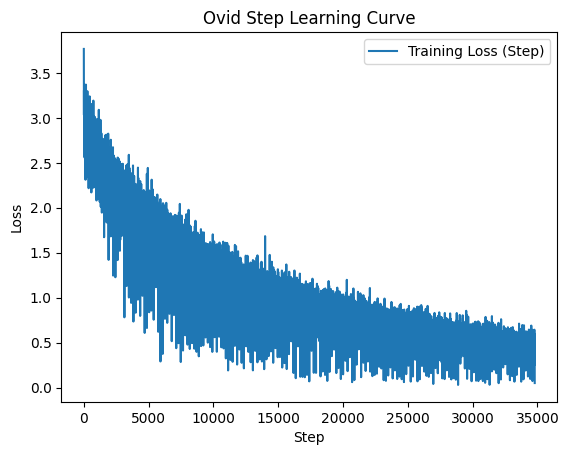

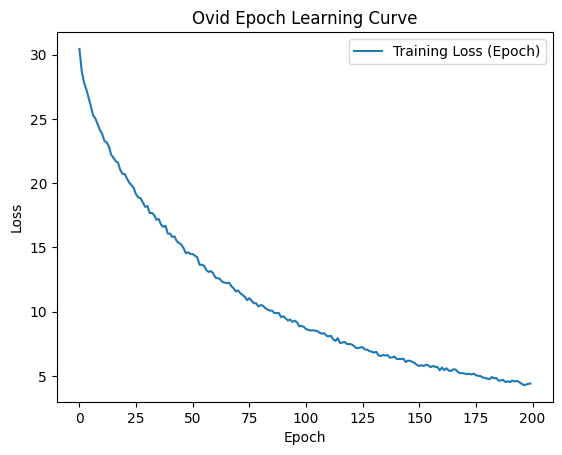

In [12]:
# plot learning curve
import matplotlib.pyplot as plt

plt.plot(train_loss_step, label='Training Loss (Step)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title(f"{author} Step Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Step_Learning_Curve.png")
plt.show()
plt.plot(train_loss_epoch, label='Training Loss (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"{author} Epoch Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Epoch_Learning_Curve.png")
plt.show()

All that remains is to save the new author weights for future inference.

In [11]:
model.save_pretrained(f"./{author}-finetuned/")

<hr>

# Running New Inference
After an author model has been trained, we can now generate new text (hopefully) in the style of the particular author. 

All that is required is to first load in the necessary weights.

In [ ]:
author = "Caesar"
tokenizer = AutoTokenizer.from_pretrained("./LatinBERT/")
model = AutoModelForMaskedLM.from_pretrained(f"./{author}-finetuned/")
model.to(device)

And, after loading in the weights, we can provide a custom prompt, encode it, and ask the model to predict its continuation. 

In [10]:
prompt = "olim nomine rufo iuvenis ingeniosus erat,".lower()
input_ids = tokenizer.encode(prompt, return_tensors='pt')
outputs = model.generate(input_ids=input_ids.to(device), max_length=50, do_sample=True)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(predicted_text)

<class 'transformers.models.bert.modeling_bert.BertForMaskedLM'>
olim nomine rufo iuvenis ingeniosus erat, sed numero hominum, quos illi attribuit, equos attribuit, arma, equos, equos attribuit. huic se atque suos attribuit ; huic marcum brutum praeficit. his copiis quintum um praeficit ; huic marcum
